In [64]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

signal = pd.read_csv("signal.csv")
bkgnd = pd.read_csv("background.csv")

In [65]:
signal['signal/bkgnd'] = 1
bkgnd['signal/bkgnd'] = 0

In [66]:
df = pd.concat([signal,bkgnd])

In [67]:
#df = df.sample(frac=1).reset_index(drop=True) #rows in random order

In [68]:
bkgnd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100331 entries, 0 to 100330
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Z_pt                100331 non-null  float64
 1   dilepton_pt         100331 non-null  float64
 2   dilepton_m          100331 non-null  float64
 3   leading_lepton_pt   100331 non-null  float64
 4   trailing_lepton_pt  100331 non-null  float64
 5   leading_muon_pt     100331 non-null  float64
 6   trailing_muon_pt    100331 non-null  float64
 7   dimuon_pt           100331 non-null  float64
 8   dxym1               100331 non-null  float64
 9   dxym2               100331 non-null  float64
 10  dxyl1               100331 non-null  float64
 11  dxyl2               100331 non-null  float64
 12  dzm1                100331 non-null  float64
 13  dzm2                100331 non-null  float64
 14  dzl1                100331 non-null  float64
 15  dzl2                100331 non-nul

**FEATURES AND LABELS**

In [69]:
#GENERAL DATA
train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus signal/bkgnd
train_y = df['signal/bkgnd'] #label = signal/bkgnd

In [70]:
#SIGNAL
signal_x = signal.drop(['signal/bkgnd'], axis=1)
signal_y = signal['signal/bkgnd']

In [71]:
#BKGND
bkgnd_x = bkgnd.drop(['signal/bkgnd'], axis=1)
bkgnd_y = bkgnd['signal/bkgnd']

In [72]:
#SAMPLING DATA
#GENERAL
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.2, 
                                                  random_state=1)
#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

**XGBClassifier**

In [103]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:logistic', max_depth = 1, learning_rate=0.3)
#fit = training
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [104]:
predict_signal = model.predict(test_signal_x)
print(np.round(accuracy_score(test_signal_y,predict_signal)*100, 2),'%')

97.16 %


In [105]:
predict2 = model.predict(test_x)
print(np.round(accuracy_score(test_y,predict2)*100, 2),'%')

99.35 %


In [106]:
predict_prob = model.predict_proba(test_signal_x)
#converting prob values to list
df_prob = pd.DataFrame(predict_prob)
s_prob_signal = df_prob[df_prob.columns[1]] 
list_prob_signal = s_prob_signal.values.tolist()

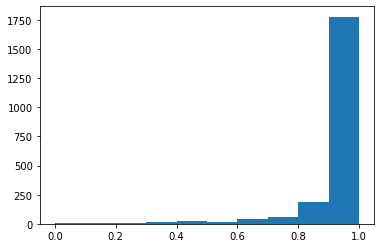

In [107]:
hist_signal = plt.hist(list_prob_signal, range=(0,1))

In [108]:
predict_prob_bkgnd = model.predict_proba(test_bkgnd_x)
df_prob_bkgnd = pd.DataFrame(predict_prob_bkgnd)
s_prob_bkgnd = df_prob_bkgnd[df_prob_bkgnd.columns[1]] 
list_prob_bkgnd = s_prob_bkgnd.values.tolist()

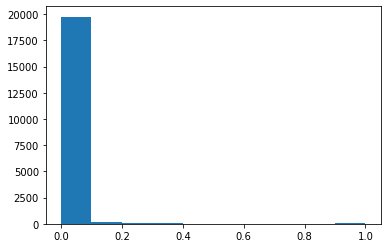

In [109]:
hist_bkgnd = plt.hist(list_prob_bkgnd, range=(0,1))

Text(0.5, 1.0, 'Signal vs Bkgnd (XGB)')

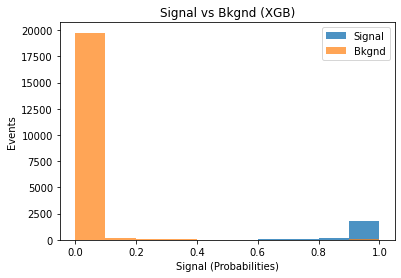

In [110]:
plt.hist(list_prob_signal, range=(0,1), alpha=0.8,label='Signal')
plt.hist(list_prob_bkgnd, range=(0,1), alpha=0.7, label='Bkgnd')
plt.legend(loc='upper right')
plt.xlabel('Signal (Probabilities)')
plt.ylabel('Events')
plt.title('Signal vs Bkgnd (XGB)')

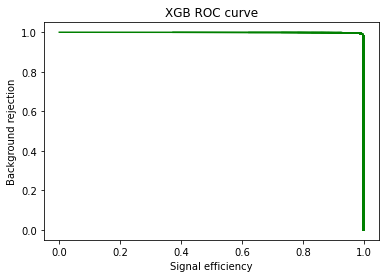

In [111]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

list_prob_signal = sorted(list_prob_signal)
list_prob_bkgnd = sorted(list_prob_bkgnd)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
efficiency = []
background_rejection = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    accepted_signal = len(list_prob_signal)
    rejected_background = 0


    for i, v in enumerate(list_prob_signal):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            accepted_signal-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(list_prob_signal)-1:
            accepted_signal=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(list_prob_bkgnd):
        if cut<=m:
            rejected_background+=i
            break
        if i==len(list_prob_bkgnd)-1:
            rejected_background=len(list_prob_bkgnd)
    
    #ALMACENA EN LA LISTA
    efficiency.append(accepted_signal/len(list_prob_signal))
    background_rejection.append(rejected_background/len(list_prob_bkgnd))

    xgbst = plt.plot(efficiency, background_rejection, color='green')
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('XGB ROC curve')

ROC AUC=  0.9993406695199442


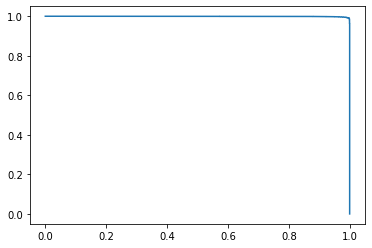

In [95]:
model_predict = model.predict_proba(test_x)
model_predict = model_predict[:,1]
auc_score = roc_auc_score(test_y, model_predict)
fpr, tpr, _ = roc_curve(test_y, model_predict)
plt.plot(tpr, 1-fpr)
print('ROC AUC= ', auc_score)
plt.show()